In [98]:
# Set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Load the cleaned heart data CSV
heart_data_path = '../data/processed/cleaned_heart_data.csv'
heart_data = pd.read_csv(heart_data_path)

# Preview the data
heart_data.head(), heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                746 non-null    int64  
 1   RestingBP          746 non-null    int64  
 2   Cholesterol        746 non-null    int64  
 3   FastingBS          746 non-null    int64  
 4   MaxHR              746 non-null    int64  
 5   Oldpeak            746 non-null    float64
 6   HeartDisease       746 non-null    int64  
 7   Sex_M              746 non-null    bool   
 8   ChestPainType_ATA  746 non-null    bool   
 9   ChestPainType_NAP  746 non-null    bool   
 10  ChestPainType_TA   746 non-null    bool   
 11  RestingECG_Normal  746 non-null    bool   
 12  RestingECG_ST      746 non-null    bool   
 13  ExerciseAngina_Y   746 non-null    bool   
 14  ST_Slope_Flat      746 non-null    bool   
 15  ST_Slope_Up        746 non-null    bool   
dtypes: bool(9), float64(1), in

(   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
 0   40        140          289          0    172      0.0             0   
 1   49        160          180          0    156      1.0             1   
 2   37        130          283          0     98      0.0             0   
 3   48        138          214          0    108      1.5             1   
 4   54        150          195          0    122      0.0             0   
 
    Sex_M  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
 0   True               True              False             False   
 1  False              False               True             False   
 2   True               True              False             False   
 3  False              False              False             False   
 4   True              False               True             False   
 
    RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
 0               True          False             Fals

In [99]:
# Set up splitting strategy
X = heart_data.drop(columns = 'HeartDisease')
y = heart_data['HeartDisease']

scoring = ['neg_log_loss', 'roc_auc', 'f1', 'accuracy', 'precision', 'recall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
#Just baseline
ST_columns_to_drop = ['MaxHR', 'Oldpeak', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']
X_train_baseline = X_train.drop(columns = ST_columns_to_drop)       
X_test_baseline = X_test.drop(columns = ST_columns_to_drop)     

#Just stress test data
Baseline_columns_to_drop = ['ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG_Normal', 'RestingECG_ST']
X_train_ST = X_train.drop(columns = Baseline_columns_to_drop)   
X_test2_ST = X_test.drop(columns = Baseline_columns_to_drop)   

#All features
X_train_all = X_train
X_test_all = X_test

In [101]:
pipe = Pipeline([
    ('clf', LogisticRegression())
])
pipe

Pipeline(steps=[('clf', LogisticRegression())])

In [102]:
pipe.get_params()

{'memory': None,
 'steps': [('clf', LogisticRegression())],
 'verbose': False,
 'clf': LogisticRegression(),
 'clf__C': 1.0,
 'clf__class_weight': None,
 'clf__dual': False,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 100,
 'clf__multi_class': 'deprecated',
 'clf__n_jobs': None,
 'clf__penalty': 'l2',
 'clf__random_state': None,
 'clf__solver': 'lbfgs',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False}

# Perform GridSearchCV
## Baseline only

In [103]:
param_grid = {
    'clf__C': [0.01, 0.5, 1.0],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear'],
    }

In [104]:
grid_cv_baseline = GridSearchCV(
    estimator=pipe, 
    param_grid=param_grid, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_log_loss")
grid_cv_baseline.fit(X_train_baseline, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.01, 0.5, 1.0],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear']},
             refit='neg_log_loss',
             scoring=['neg_log_loss', 'roc_auc', 'f1', 'accuracy', 'precision',
                      'recall'])

In [105]:
res = grid_cv_baseline.cv_results_
res_baseline = pd.DataFrame(res)
res_baseline.columns

res_baseline[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'params', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy']].sort_values('rank_test_accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
5,0.001452,0.000067,0.004287,0.000052,"{'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__so...",0.755056,0.034836,1
2,0.005729,0.000317,0.004386,0.000084,"{'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__so...",0.751695,0.028256,2
3,0.001457,0.000077,0.004430,0.000159,"{'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__so...",0.748347,0.037011,3
4,0.005954,0.000172,0.004424,0.000172,"{'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__so...",0.748333,0.031338,4
1,0.001707,0.000737,0.004624,0.000392,"{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__s...",0.649244,0.031521,5
0,0.013161,0.021509,0.007135,0.003983,"{'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__s...",0.558683,0.034342,6


In [106]:
grid_cv_baseline.best_params_

{'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}

In [107]:
final_model_baseline = grid_cv_baseline.best_estimator_

## Add stress test metrics to model

In [108]:
grid_cv_all = GridSearchCV(
    estimator=pipe, 
    param_grid=param_grid, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_log_loss")
grid_cv_all.fit(X_train_all, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.01, 0.5, 1.0],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear']},
             refit='neg_log_loss',
             scoring=['neg_log_loss', 'roc_auc', 'f1', 'accuracy', 'precision',
                      'recall'])

In [109]:
res = grid_cv_all.cv_results_
res_all = pd.DataFrame(res)
res_all.columns

res_all[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'params', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy']].sort_values('rank_test_accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
3,0.002007,0.000240,0.005316,0.000805,"{'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__so...",0.840602,0.032333,1
4,0.006620,0.002126,0.004964,0.000409,"{'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__so...",0.837255,0.034652,2
5,0.001791,0.000130,0.004468,0.000164,"{'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__so...",0.833880,0.031234,3
2,0.003905,0.000704,0.005057,0.000687,"{'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__so...",0.830532,0.035031,4
1,0.001772,0.000114,0.005258,0.000589,"{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__s...",0.810350,0.040539,5
0,0.003180,0.000326,0.005731,0.000811,"{'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__s...",0.691204,0.045318,6


In [110]:
grid_cv_all.best_params_

{'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

In [111]:
final_model_all = grid_cv_all.best_estimator_

# Evaluate the performance of the models

In [112]:
# Obtain the predicted probabilities
y_test_prob_baseline = final_model_baseline.predict_proba(X_test_baseline)[:, 1]
y_test_prob_all = final_model_all.predict_proba(X_test_all)[:, 1]

# Visualize accuracy metrics

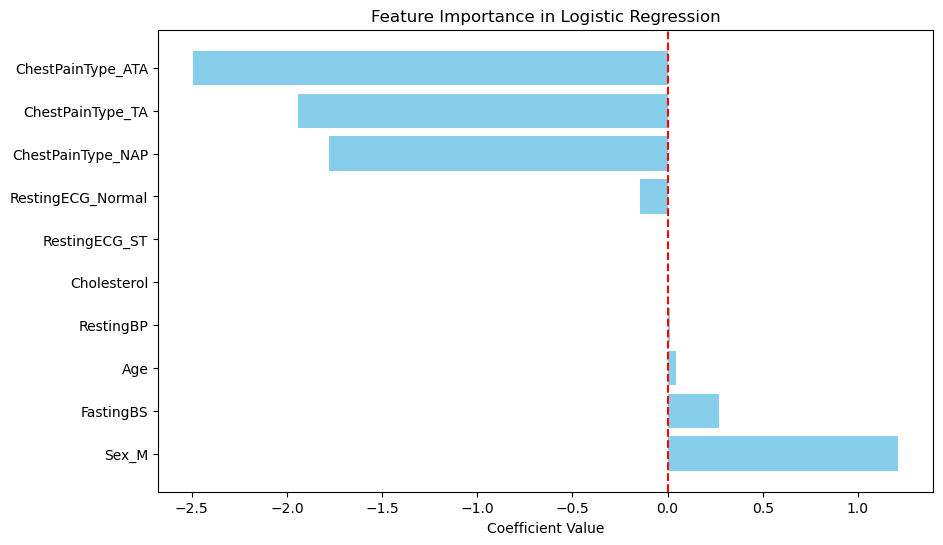

In [116]:
logistic_model_baseline = final_model_baseline.named_steps["clf"]

# Get feature names and coefficients
feature_names = X_train_baseline.columns
coefficients = logistic_model_baseline.coef_[0]

# Create a DataFrame for visualization
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Logistic Regression")
plt.show()


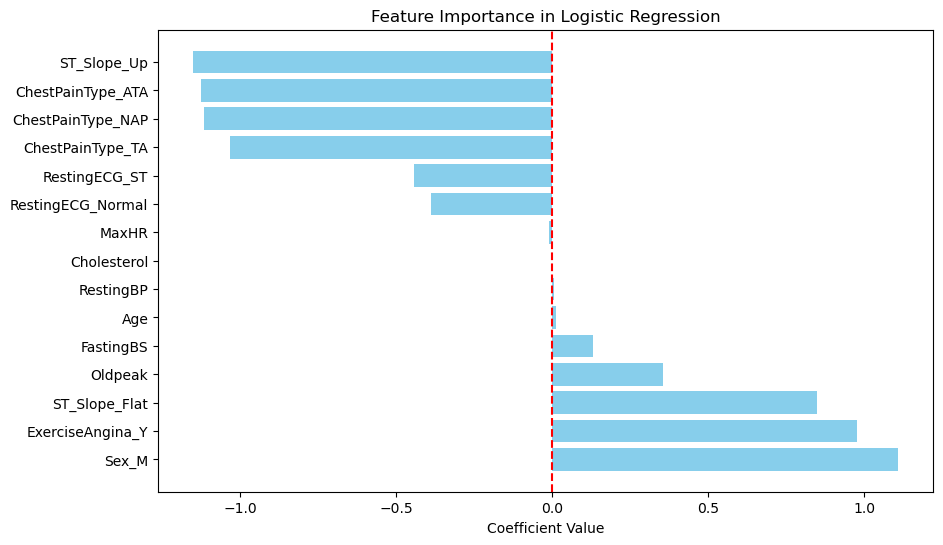

In [119]:
logistic_model_all = final_model_all.named_steps["clf"]

# Get feature names and coefficients
feature_names = X_train_all.columns
coefficients = logistic_model_all.coef_[0]

# Create a DataFrame for visualization
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Logistic Regression")
plt.show()

# Compare ROC Curves

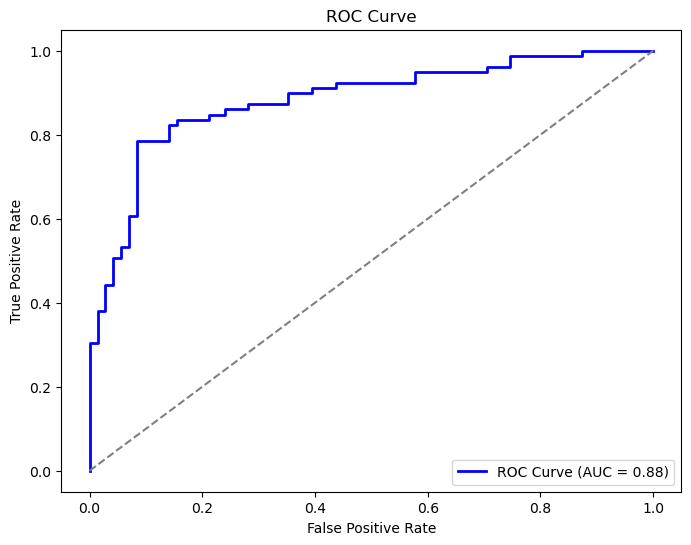

In [120]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob_all)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


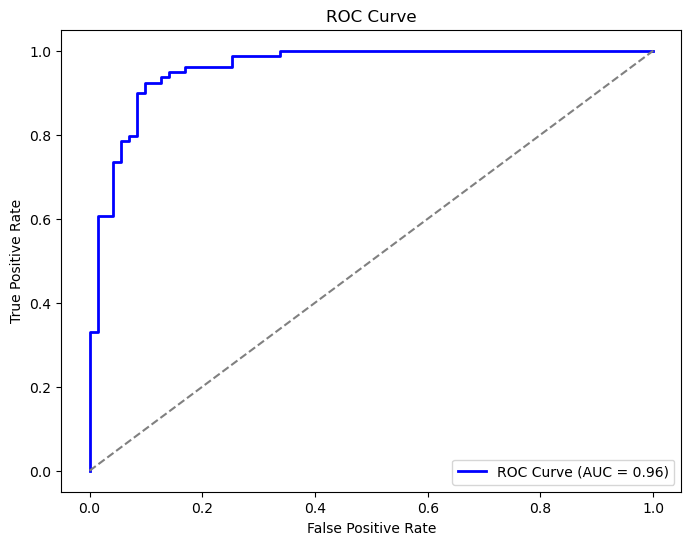

In [122]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob_all)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

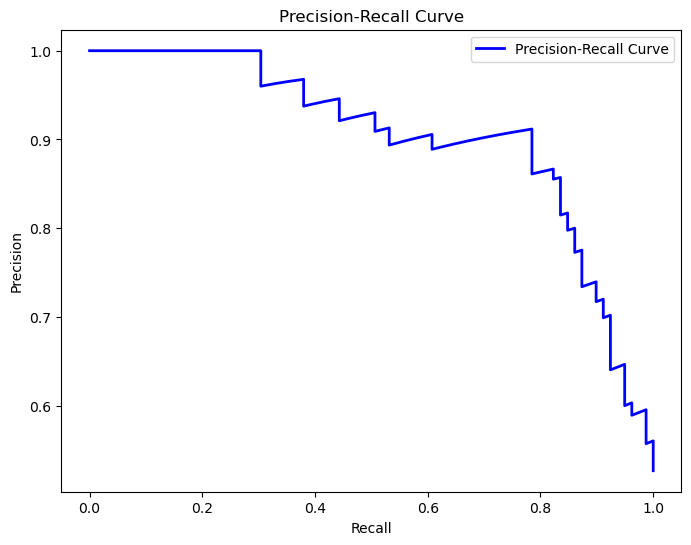

In [124]:
from sklearn.metrics import precision_recall_curve

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob_baseline)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


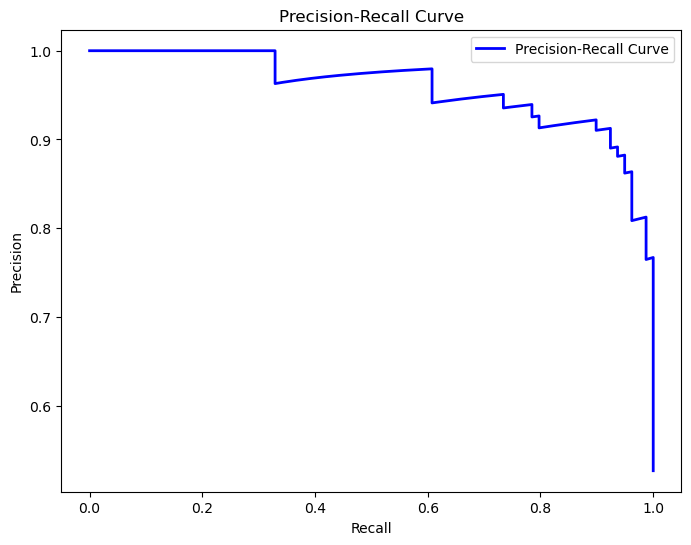

In [123]:
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob_all)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

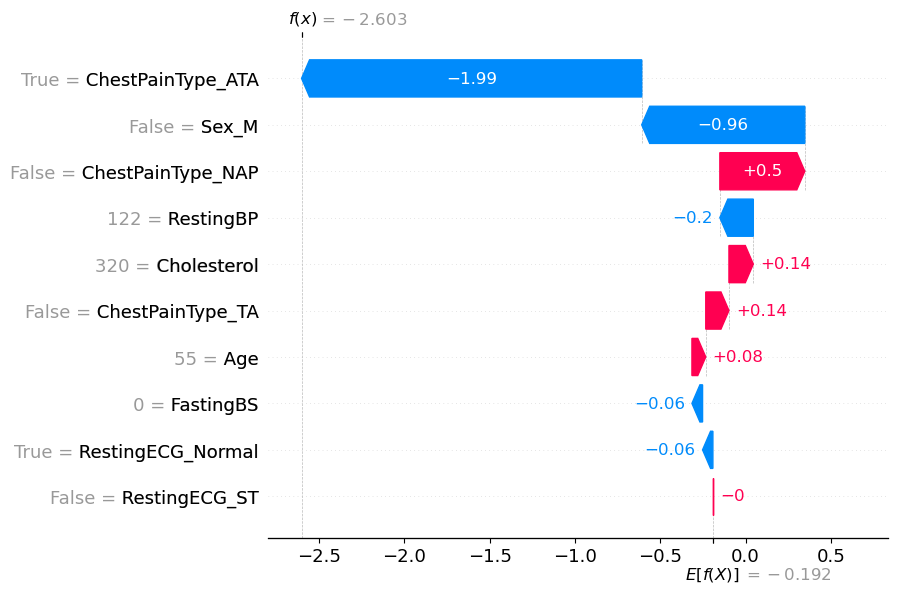

In [135]:
import shap
classifier_baseline = final_model_baseline.named_steps['clf']

explainer = shap.explainers.Linear(
    classifier_baseline,
    X_test_baseline,
    feature_names = X_test_baseline.columns
)

shap_values_baseline = explainer(X_test_baseline)
shap.plots.waterfall(shap_values_baseline[1])

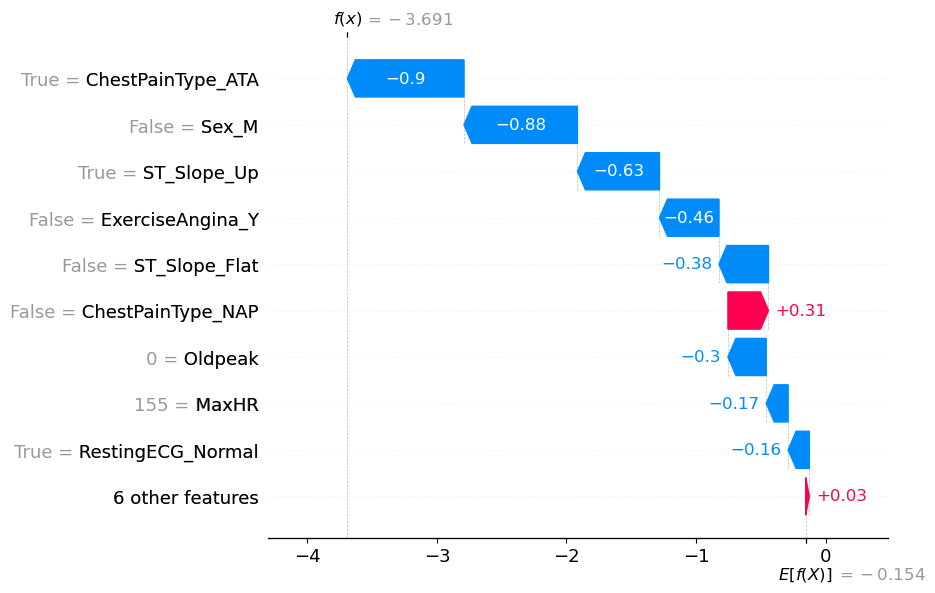

In [136]:
import shap
classifier_all = final_model_all.named_steps['clf']

explainer = shap.explainers.Linear(
    classifier_all,
    X_test_all,
    feature_names = X_test_all.columns
)

shap_values_all = explainer(X_test_all)
shap.plots.waterfall(shap_values_all[1])

# Export models

In [126]:
import pickle
import os

save_directory = "../models"
os.makedirs(save_directory, exist_ok=True)

with open(os.path.join(save_directory, 'LR_best_model_baseline.pkl'),'wb') as f: 
           pickle.dump(final_model_baseline, f)

with open(os.path.join(save_directory, 'LR_best_model_all.pkl'),'wb') as f: 
           pickle.dump(final_model_all, f)